## MVP

Here, I will outline steps for my MVP, including Data Loading, Data Cleaning, and Preperation of Data for Training

In [10]:
import requests
import pandas as pd
import time


Get API Key from Google Collab Account

In [11]:
from Keys import API_KEY

API_KEY = API_KEY

In [12]:
from googleapiclient.discovery import build
youtube = build('youtube','v3', developerKey = API_KEY)

In [13]:
world_cities = pd.read_csv('worldcities.csv')
world_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [14]:
world_cities_first = world_cities[0:20]
world_cities_second = world_cities[20:][world_cities['country'] != 'China']
world_cities = pd.concat((world_cities_first,world_cities_second), axis = 0).reset_index(drop = True)


C:\Users\kenhu\AppData\Local\Temp/ipykernel_6756/3597982440.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  world_cities_second = world_cities[20:][world_cities['country'] != 'China']


Next, we need to pull data from API. We will write a function to do this. There are two steps to this:

1. Search: We are searching the most popular videos pertaining to the key word: "[City name] + travel". From this, we can obtain the Video ID for the top 50 items.
2. Video: From Video ID, we can find the Video title + Views


In [15]:
json_list = []
def search_city(x):

    city = x[1]
    print(city)
    search_list = youtube.search().list(
        part="snippet",
        maxResults = 50,
        q="travel " + city,
        order = 'viewCount',
        type="video"
        ).execute()
    json_list.append(search_list)
    videos = pd.DataFrame(columns = ['video_id','video_title','view_count'])
    vid_title_list = []
    vid_id_list = []
    vid_count_list = []
    for i in range(0, len(search_list['items'])):
        vid_title_list.append(search_list['items'][i]['snippet']['title'])
        
        vid_id = search_list['items'][i]['id']['videoId']
        vid_id_list.append(vid_id)
        
        videostats = youtube.videos().list(part = 'statistics', id = vid_id).execute()
        vid_count_list.append(videostats['items'][0]['statistics']['viewCount'])
        
    
    vid_data = [vid_id_list, vid_title_list, vid_count_list]
    return vid_data


We then need to format the data out from the API pull to a dataframe

In [16]:
world_data = pd.DataFrame(columns = ['video_id','video_title','view_count'])

for i in range(332,390,2):
    world_city_sample = world_cities.iloc[i:i+2]
    world_city_sample['scraped_data'] = world_city_sample.apply(search_city, axis = 1)

    for j in range(i, i + world_city_sample.shape[0]):
        temp_data = pd.DataFrame(columns = ['video_id','video_title','view_count'])
    
        temp_data = temp_data.append({'video_id': world_city_sample['scraped_data'].explode().loc[j].iloc[0],
                          'video_title': world_city_sample['scraped_data'].explode().loc[j].iloc[1],
                          'view_count': world_city_sample['scraped_data'].explode().loc[j].iloc[2]}, ignore_index = True)
        world_data = world_data.append(temp_data)

world_data_cleaned = world_data.apply(pd.Series.explode)
world_data_cleaned.head()

Amritsar
Callao


C:\Users\kenhu\AppData\Local\Temp/ipykernel_6756/2564604654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_city_sample['scraped_data'] = world_city_sample.apply(search_city, axis = 1)


Aligarh
Tegucigalpa
Ciudad Nezahualcoyotl
Tripoli
Rostov
Nezahualcoyotl
Bhiwandi
Tbilisi
Ufa
Fes
Sevilla
Mexicali
Bien Hoa
Gwalior
Ikare
Huambo
Salt Lake City
Bhilai
N'Djamena
Irbid
Haora
Cologne
Krasnoyarsk
Sao Goncalo
Nashville
Yerevan
Ranchi
Nur-Sultan
Nouakchott
Vereeniging
Richmond
Sao Luis
San Pedro Sula
Memphis
Goyang
Bezwada
Edmonton
Tunis
Barquisimeto
Sendai
Voronezh
Perm
Changwon
Bogor
Raleigh
Cartagena
Chandigarh
Bishkek
Matola
Ogbomoso
Ashgabat
Maceio
Niamey
Managua
Patam
Tekirdag


,video_id,video_title,view_count
0,0BdeoItL7a8,"THE GOLDEN TEMPLE | AMRITSAR, INDIA",847011
0,Og1SoLz-FlY,Top 10 Things To Do / See || Amritsar,613244
0,0tiq1kpV_6U,Amritsar Top 10 Tourist Places In Hindi | Amri...,444569
0,PfGItt-Fu3M,Punjab is AMAZING | Ep5 Amritsar &amp; The Gol...,396062
0,5flGGYzh_uE,Amritsar Tourist Places | Amritsar Tour Plan &...,328504


I am going to save these files so I can load them later on. The Youtube API unfortunately has a daily limit, so I make API calls every day and am saving the information.

In [17]:
world_data_cleaned.to_csv('Scraped_Data/world_data_220116.csv')


Loading all files from all API scrapes and combining them all into one dataframe.

In [21]:
def get_filelist(img_folder, filetype = 'csv'):
    img_filelist = []
    for root, subdirectories, files in os.walk(img_folder):
        for file in files:
            if file.endswith(filetype):
                img_filelist.append(os.path.join(root, file))
    return img_filelist

file_list = get_filelist('Scraped_Data')

files = []
for path in file_list:
    file = pd.read_csv(path)
    files.append(file)

files = pd.concat(files, ignore_index=True, join='outer', axis=0)
files['video_title'] = files['video_title'].astype('str')

### EDA

It's helpful to do some data visualization to look at our data. Here, I'm going to look at the 20 most popular words in my corpus, to see if it makes sense and so I have a better idea of what the popular titles for travel videos look like.

In [22]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(files.video_title)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = files.index
data_dtm

C:\Users\kenhu\anaconda3\envs\mask_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000km,001,002,002б,003,004,005щ,006,...,𝐓𝐑𝐀𝐕𝐄𝐋,𝐓𝐨,𝐓𝐫𝐚𝐯𝐞𝐥,𝐓𝐫𝐚𝐯𝐞𝐥𝐬,𝐴𝑙𝑎𝑔𝑜𝑎𝑠,𝐺𝑜𝑖𝑎𝑠,𝑭𝒐𝒓𝒕𝒂𝒍𝒆𝒛𝒂,𝑱𝒂𝒑𝒂𝒏,𝑻𝒓𝒂𝒗𝒆𝒍,𝑽𝒍𝒐𝒈
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='0'>

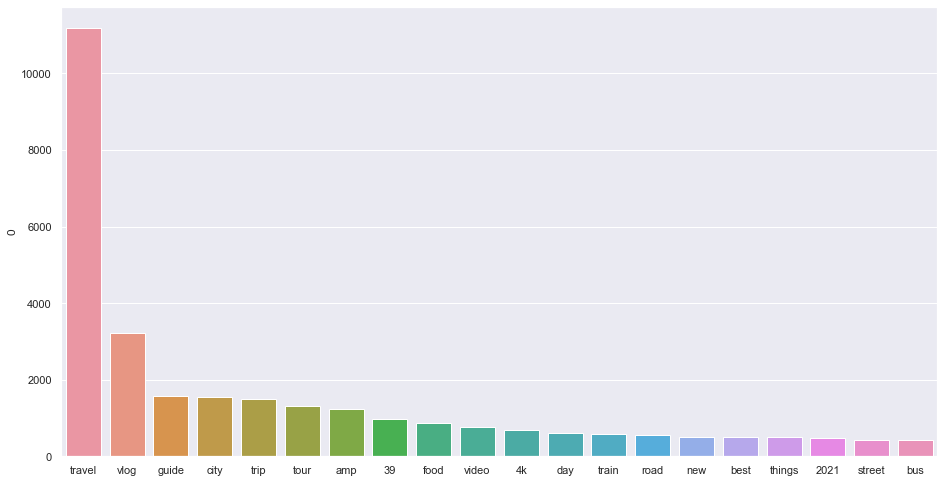

In [24]:
word_list = data_dtm.sum(axis = 0, skipna = True).sort_values(ascending = False)
word_list[0:20]
word = pd.DataFrame(word_list[0:20])
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(x = word.index, y = word[0])

It looks normal to me for the most part, but a couple things are more random like amp and 39, and those could be errors. So, after this MVP, I will definetely spend more time on data cleaning/preprocessing to clean up my data.

### Preparing the Data For Modeling

For my MVP, I will prepare the data to the format for modeling. In my MVP, I am trying a character prediction. So the prediction will be on what the next character in the sequence is. For my final project, I may try to use word embeddings and a bidirectional LSTM so that I can do word prediction

In [56]:
titles = files['video_title']
title_list = list(titles)
title_sample = title_list
raw_text = ''.join(title_sample)

files

,Unnamed: 0,video_id,video_title,view_count
0,0,3r4x4tztZ7E,"11 Things To Do in Yangon, Myanmar (Are You Re...",949267.0
1,0,QFsmfF77GEI,"Vlog - 3 | Yangon, Myanmar Diaries | Travel vl...",635046.0
2,0,z1D1P9-_oNA,MYANMAR STREET FOOD TOUR in Yangon | Delicious...,540365.0
3,0,UivJLq-anyk,"A Taste of Yangon, Burma (Myanmar) - Burmese S...",440729.0
4,0,8Ai6AZfUcSM,"On Board With President Obama - Rangoon, Burma",304705.0
...,...,...,...,...
16610,0,e6UMHe5HW_c,AKCAKOCA | ZONGULDAK | ANKARA | CANAKKALE | TE...,115.0
16611,0,mBZqS3a85Ws,Usa ko new city travel TEKIRDAG to KOCAELI🚌🚌🚌🚌...,17.0
16612,0,fky2PiOz-Rs,10º Viaje. Tallin (Estonia) - Tekirdag (Turquí...,16.0
16613,0,78MYia_NaHk,Travel TEKIRDAG TO SANLIURFA BUS SIMULATOR UNL...,8.0


Count up all characters in the corpus and make dictionary to map word to integer.

In [27]:
chars = sorted(list(set(raw_text))) #List of every character
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)


Total Characters in the text; corpus length:  1063228
Total Vocab:  2682


Define size of dimensions of your variables

In [34]:
num_classes = n_vocab
batch_size = 100
learning_rate = 0.001

input_size = n_vocab
sequence_length = 30
hidden_size = 128
num_layers = 2


In order to standardize the length of each input vector, we need to create sequences that are the same length. For each sentence, we will create sequences of length 30, with shifts of 3 to cover different parts of that sequence. This way we capture a large percentage of each sentence, while still moving through the sentence list.

In [31]:
#For creating X-Y text input data from each title given:
seq_length = 30  #Length of each input sequence
step = 3   #Instead of moving 1 letter at a time, try skipping a few.
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for title in title_sample:
    if seq_length > len(title):
        for i in range(0, len(title), step):  #step=1 means each sentence is offset just by a single letter
            sentences.append(f"{title[0: len(title) - i].rjust(seq_length)}")  #Sequence in
            try:
                next_chars.append(title[len(title) - i])  #Sequence out
            except:
                next_chars.append(' ')
        n_patterns = len(sentences)
    else:
        for i in range(0, len(title), step):  #step=1 means each sentence is offset just by a single letter
            start_point = len(title) - seq_length - i
            if start_point >= 0:
                sentences.append(f"{title[len(title) - seq_length - i: len(title) - i].rjust(seq_length)}")  #Sequence in
            else:
                sentences.append(
                    f"{title[0: len(title) - i].rjust(seq_length)}")  # Sequence in
            try:
                next_chars.append(title[len(title) - i])  #Sequence out
            except:
                next_chars.append(' ')


Turn the sequences into numpy arrays of fixed size, that can be processed by a neural network

In [33]:
import numpy as np

x = np.zeros((len(sentences), seq_length, n_vocab), dtype=bool)
y = np.zeros((len(sentences), n_vocab), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

x = x.astype('float32')
y = y.astype('float32')
print(x.shape)
print(y.shape)

(360057, 30, 2682)
(360057, 2682)


Use custom DataSet and DataLoader to structure data and load to model in increments

In [36]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        sample = {"x": x, "y": y}
        return sample

t_DS = TextDataset(x,y)
loader = DataLoader(t_DS ,batch_size = 256)


## Modeling

### Training

Create RNN class first, can try LSTM and GRU architecture later on.

In [37]:
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out


Create model object from RNN class, then specify training parameters

In [38]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
EPOCHS = 15
BATCH_SIZE = 256


Specific Loss function and Optimizer

In [39]:
from torch.optim import Adam, RMSprop
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  


Create Training Loop for specified amount of epochs

In [40]:
for epoch in range(EPOCHS):
    loss = 0
    correct = 0
    for i, data in tqdm(enumerate(loader)):
        x_train, y_train = data['x'], data['y']
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print('Epoch {} Loss : {}'.format((epoch+1),loss))


1407it [05:07,  4.58it/s]


Epoch 1 Loss : 3.1072957515716553


1407it [06:43,  3.49it/s]


Epoch 2 Loss : 2.9314215183258057


466it [03:03,  2.54it/s]


KeyboardInterrupt: 

### Testing

Still in progress, need further training, and to fix testing loop

In [51]:
x_test_set = x[0:5000,:,:]
y_test_set = y[0:5000,:]

In [52]:
test_DS = TextDataset(x_test_set,y_test_set)
test_loader = DataLoader(test_DS ,batch_size = 256)


In [57]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, data in tqdm(enumerate(test_loader)):
        x_test, y_test = data['x'], data['y']
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)
        
        #_, predicted = torch.max(outputs.data, 1)
        n_samples += y_test.size(0)
        n_correct += (outputs == y_test).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
  


13it [00:00, 21.63it/s]


KeyboardInterrupt: 